<a href="https://colab.research.google.com/github/anelglvz/Deep_Learning/blob/main/stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion** 

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

In [ ]:
!nvidia-smi

Thu Apr 13 00:57:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   8647MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)  

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Next, let's move the pipeline to GPU to have faster inference.

In [ ]:
pipe = pipe.to("cuda")

we can generate images

  0%|          | 0/50 [00:00<?, ?it/s]

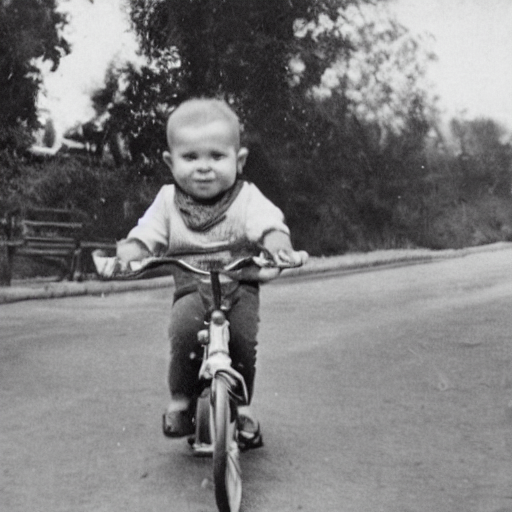

In [ ]:
prompt = "a photograph of a baby riding a bike"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
#image.save(f"astronaut_rides_horse.png")

# or if you're in a google colab you can directly display it with 
image

unning the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

  0%|          | 0/50 [00:00<?, ?it/s]

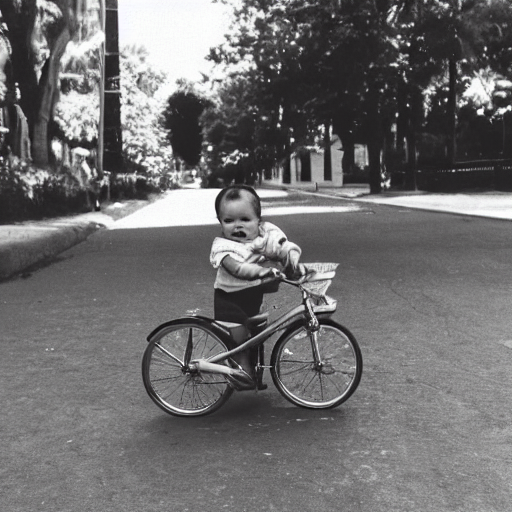

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, generator=generator).images[0]

image

Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

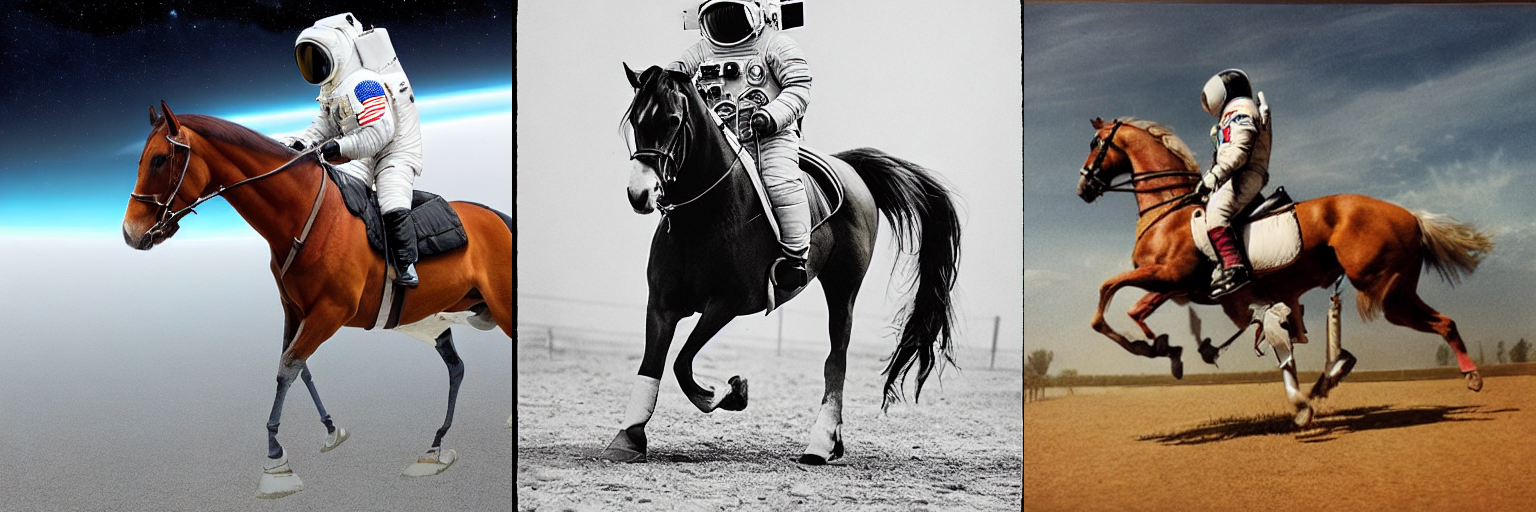

In [ ]:
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

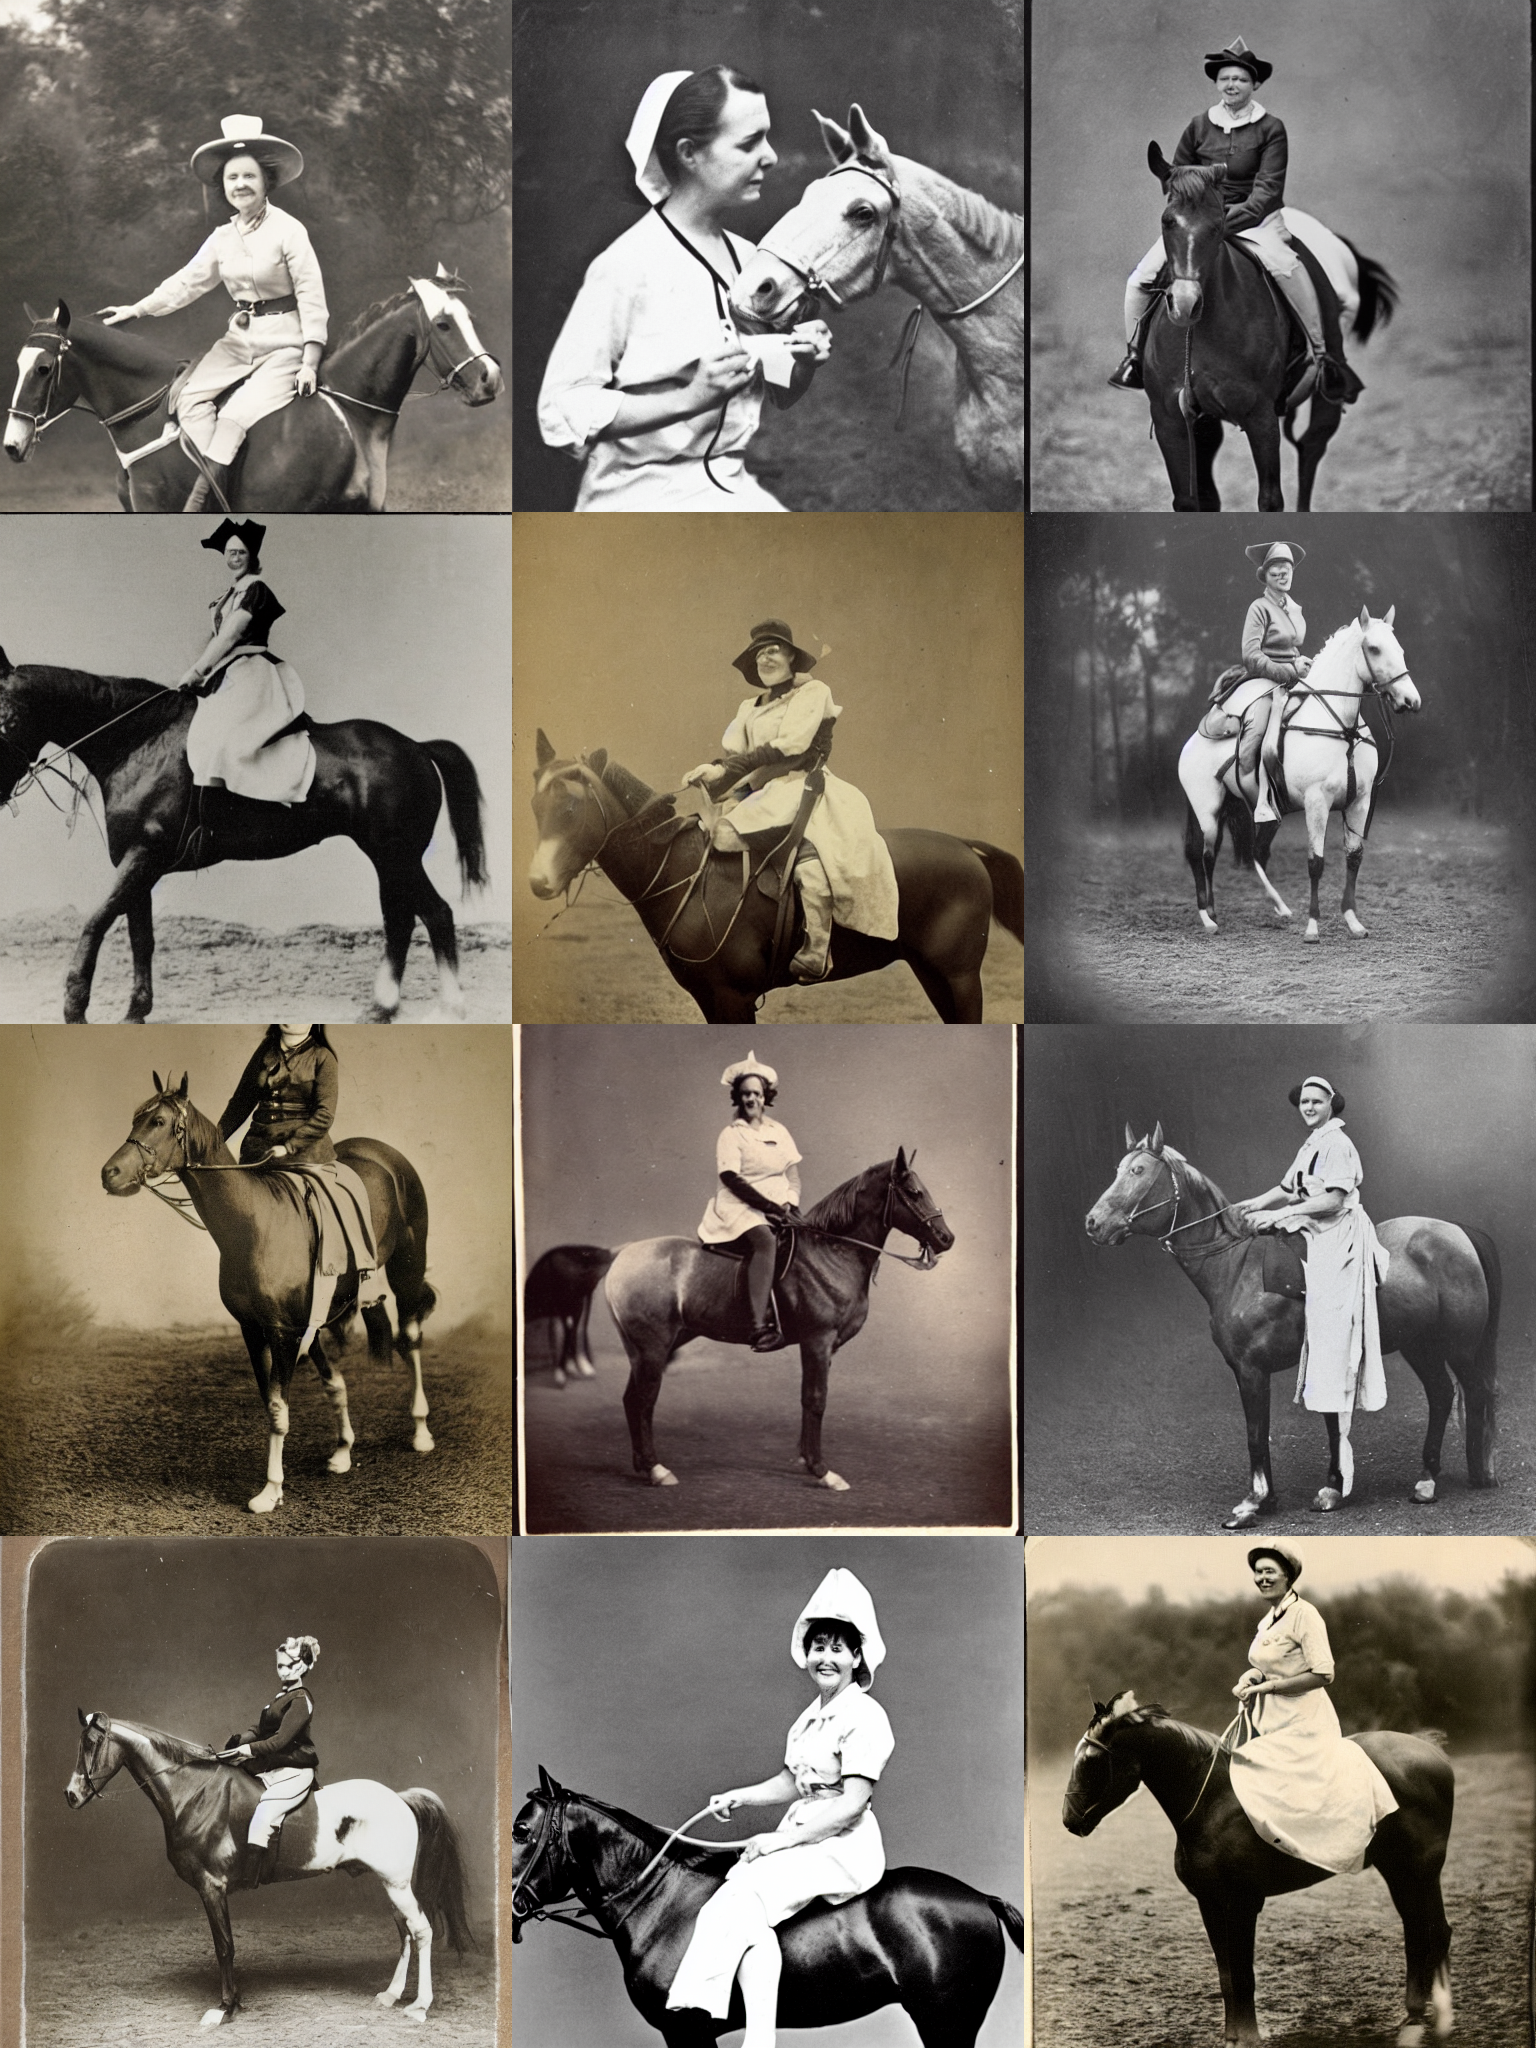

In [ ]:
num_cols = 3
num_rows = 4

prompt = ["a photograph of a nurse riding a horse"] * num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.** 

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!


Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components. 

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
latents.shape

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiply the `latents` by its `sigma` values. Let's do this here

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

And finally, let's convert the image to PIL

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]